In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import requests as req
import json
import multiprocessing as mp


from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.plotting.plot import bocd_plot_comp
from curvemetrics.src.classes.model import BOCD

Adding /root/curve-lp-metrics to sys.path


In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [4]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2023-02-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-04-01"))

In [5]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)
tokens = {token_metadata[v]['symbol']:v for v in set(swaps_data['tokenBought'])}
ohlcvs = {}
for k, v in tokens.items():
    ohlcv = datahandler.get_ohlcv_data(v, start=start_ts, end=end_ts)
    ohlcvs[v] = ohlcv

In [6]:
async def get_snapshots():
    datafetcher = DataFetcher(token_metadata=token_metadata)
    try:
        snapshots = datafetcher.get_snapshots(start_ts, end_ts, pool)
    except Exception as e:
        print(f'excepted: {e}')
        return 
    finally:
        await datafetcher.close()
    return snapshots
    
snapshots = await get_snapshots()
snapshots = DataHandler.format_pool_snapshots(snapshots)
snapshots = snapshots.sort_values(by='timestamp')
snapshots.index = snapshots['timestamp'].apply(datetime.fromtimestamp)

In [7]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata, freq='1min')

pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data, ohlcvs)
lp_share_price = metricsprocessor.lp_share_price(pool, pool_data, ohlcvs)
cps, error, vp, rp = metricsprocessor.true_cps(lp_share_price, snapshots)

<Axes: xlabel='timestamp'>

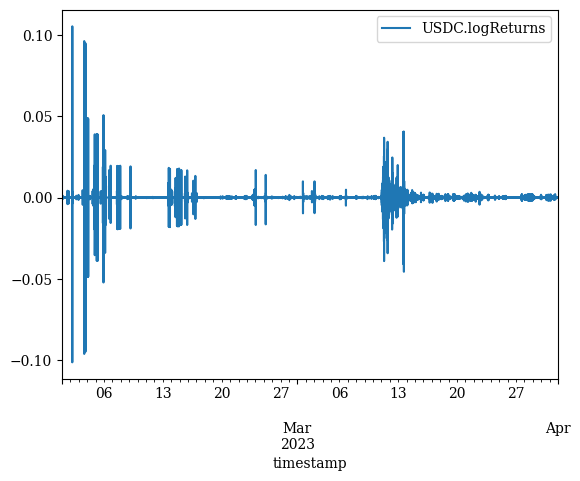

In [55]:
token = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
token_metrics = metricsprocessor.process_metrics_for_token(token, ohlcvs[token])
token_metrics.plot()

<Axes: xlabel='timestamp'>

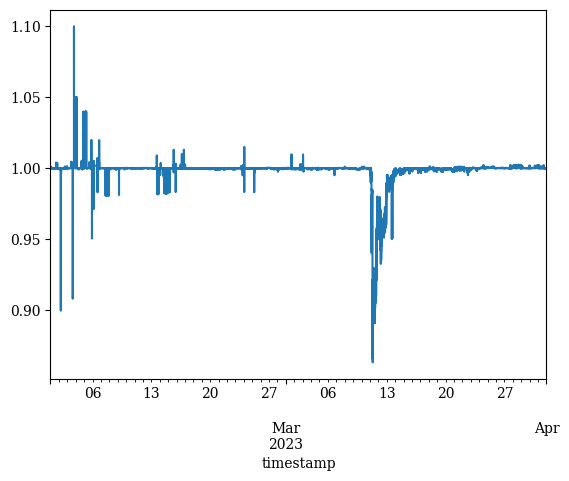

In [56]:
ohlcvs[token]['close'].plot()

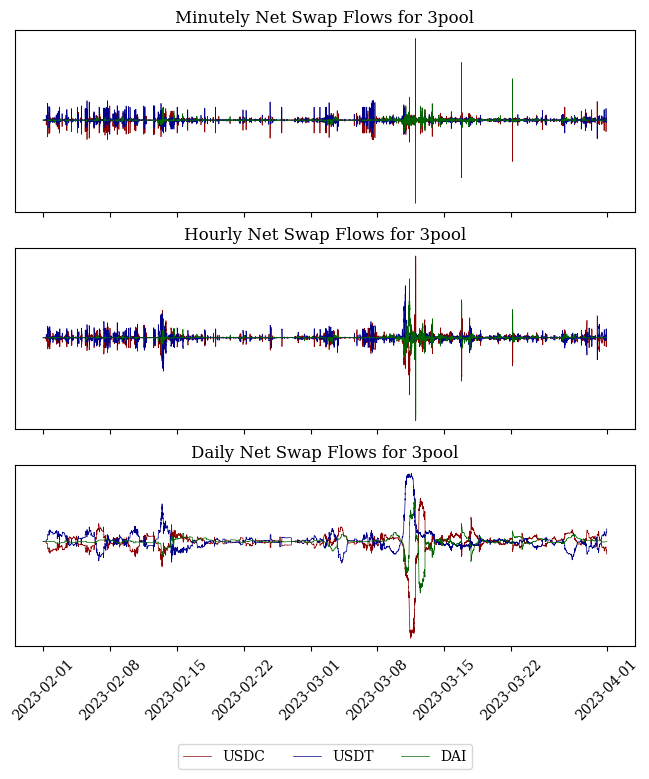

In [8]:
f, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

titles = ['Minutely', 'Hourly', 'Daily']
freqs = ['1min', '1h', '1d']

for i, ax in enumerate(axs):

    usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    dai_flow = pool_metrics['DAI.netSwapFlow'].rolling(freqs[i]).sum() / 1e6

    ax.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5, c='darkred')
    ax.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5, c='darkblue')
    ax.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5, c='darkgreen')

    # ax.grid(True)
    ax.set_title(f'{titles[i]} Net Swap Flows for 3pool')
    ax.set_yticks([])
    
ax.tick_params(axis='x', rotation=45)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
f.savefig('../figs/3pool_swap_flows.png', bbox_inches='tight')

# Grid Search

In [69]:
# alpha = [10**i for i in range(1, 5)]
# beta = [10**i for i in range(-5, -1)]
# kappa = [10**i for i in range(-5, -1)]

alpha = [10**i for i in range(1, 2)]
beta = [10**i for i in range(-3, -2)]
kappa = [10**i for i in range(-3, -2)]

grid = [[a, b, k] for a in alpha for b in beta for k in kappa]
print(len(grid))

1


In [26]:
y, _, _, _ = metricsprocessor.true_cps(lp_share_price, snapshots)

In [28]:
freq = '1min'
X = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).dropna().resample(freq).mean()
port = lp_share_price.resample(freq).mean()

bocd = BOCD()
results = bocd.tune(grid, X, y)

         99 function calls in 83.063 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4   83.041   20.760   83.041   20.760 {method 'acquire' of '_thread.lock' objects}
        1    0.016    0.016    0.021    0.021 /root/curve-lp-metrics/venv/lib/python3.10/site-packages/multiprocess/pool.py:471(_map_async)
        1    0.005    0.005    0.005    0.005 {method 'put' of '_queue.SimpleQueue' objects}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        2    0.000    0.000    0.000    0.000 {built-in method posix.cpu_count}
        1    0.000    0.000   83.063   83.063 /root/curve-lp-metrics/curvemetrics/src/detection/tuner.py:82(tune)
        2    0.000    0.000    0.000    0.000 /usr/lib/python3.10/contextlib.py:102(__init__)
        2    0.000    0.000    0.000    0.000 /usr/lib/python3.10/codeop.py:117(__call__)
        1    0.000    0.000    0.000    0.000 /root/curve-lp-metrics/

In [48]:
cps = metricsprocessor.true_cps(lp_share_price, snapshots)
foo = DataHandler.format_changepoints(cps, pool, 'baseline', 'baseline')
foo

,pool_id,model,metric,timestamp
0,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1675461120
1,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678509060
2,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678509360
3,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678509900
4,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678513680
5,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678514280
6,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678518240
7,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678555920
8,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678557180
9,0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7,baseline,baseline,1678558680


In [43]:
pd.DataFrame(cps, columns=['timestamp'])

,timestamp
0,2023-02-03 21:52:00
1,2023-03-11 04:31:00
2,2023-03-11 04:36:00
3,2023-03-11 04:45:00
4,2023-03-11 05:48:00
5,2023-03-11 05:58:00
6,2023-03-11 07:04:00
7,2023-03-11 17:32:00
8,2023-03-11 17:53:00
9,2023-03-11 18:18:00


In [71]:
tuner.best_params

(10, 0.001, 0.001)

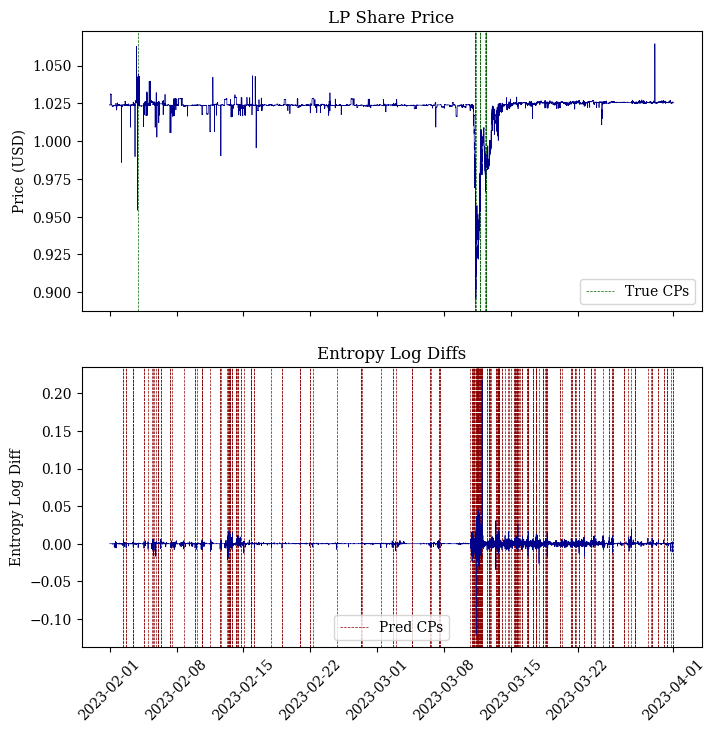

In [30]:
a, b, k = bocd.best_params
bocd.update({'alpha': a, 'beta': b, 'kappa': k})
pred = bocd.predict(X)
bocd_plot_comp(X, port, cps, pred)

(0.1515151515151515, 1.0, 0.125)


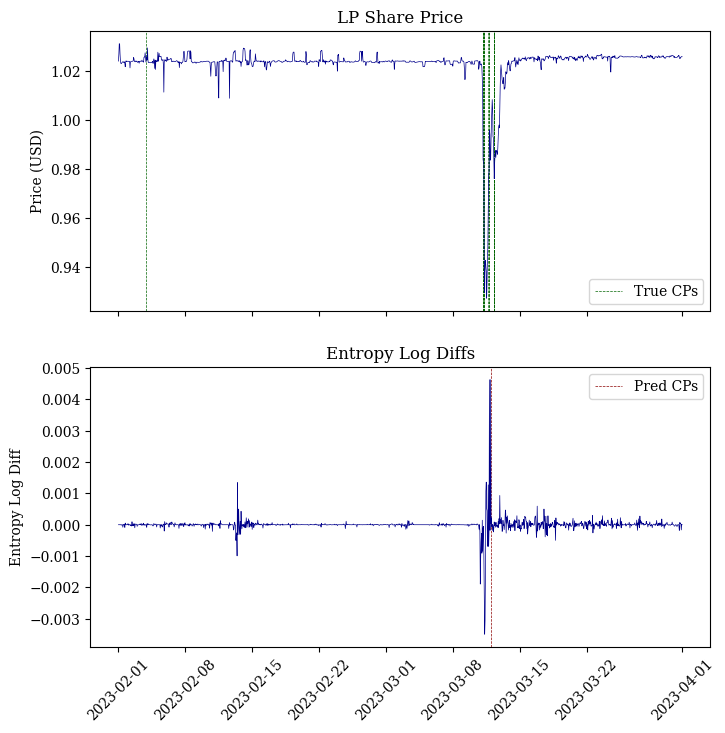

In [ ]:
a, b, k = max(results, key=lambda x: results[x][1])
print(results[(a, b, k)])
pred = predict(metric, {'lambda': 100, 'alpha': a, 'beta': b, 'kappa': k, 'mu': 0})
bocd_plot_comp(metric, port, cps, pred)

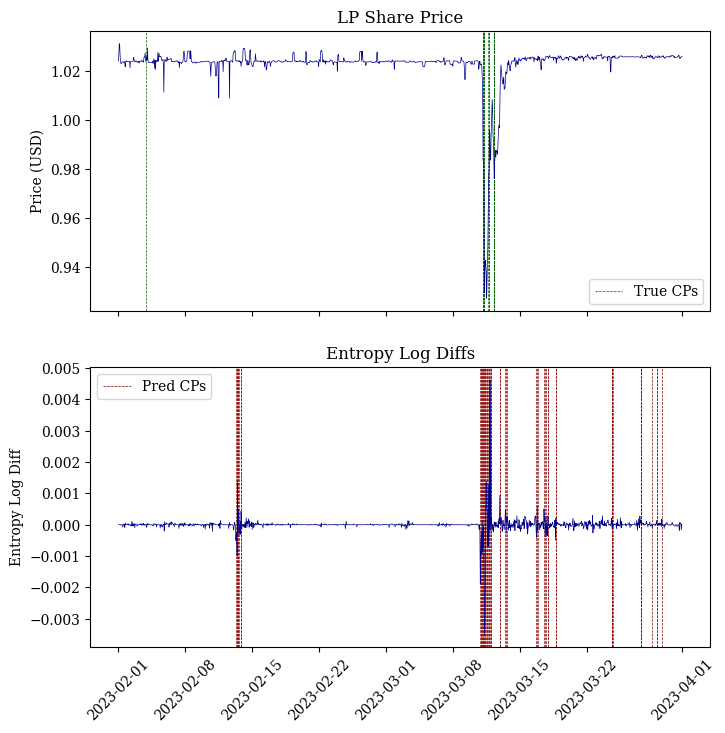

: 

In [ ]:
a, b, k = max(results, key=lambda x: results[x][2])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)